# Imports

In [111]:
import pandas as pd
import numpy as np
from Bio import SeqIO
import io
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.figure import Figure
import vcf
import matplotlib.lines as mlines
from tqdm.notebook import tqdm
import collections

Run the second line and type in the full path of where the Clade Analysis folder and its contents are located on your local machine when prompted to do so.  

Example Input (will be different on your local machine): /Users/davidchen/Documents/COVID-19_Mutation_signature/Clade_Analysis

In [2]:
directory = input("Print the full file path of your local directory to the Clade Analysis Folder: ")

Print the full file path of your local directory to the Clade Analysis Folder: /Users/davidchen/Documents/GitHub/Mutation_Signature/Clade_Analysis


# Settings

In [3]:
#pd.set_option('display.max_columns', None)  
#pd.set_option('display.max_rows', None)  
#pd.set_option('display.max_colwidth', 500)
plt.style.use('classic')

In [4]:
protein_loci = pd.read_csv("SARS_proteins_loci.txt", sep="\t")
protein_loci

,#chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd,reserved,blockCount,...,geneType,dbName,annotationType,position,longName,syns,subCellLoc,comments,uniProtId,pmids
0,NC_045512v2,265,805,nsp1,1000,+,265,805,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 1-180 on protein P0DTC1,Non-structural protein 1,NaN,NaN,Inhibits host translation by interacting with ...,P0DTC1,NaN
1,NC_045512v2,265,21552,pp1ab,1000,+,265,21552,"12,12,120",2,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 1-7096 on protein P0DTD1,Replicase polyprotein 1ab,pp1ab; ORF1a-1b; ORF1ab polyprotein; Replicase...,NaN,Multifunctional protein involved in the transc...,P0DTD1,NaN
2,NC_045512v2,265,13480,pp1a,1000,+,265,13480,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 1-4405 on protein P0DTC1,Replicase polyprotein 1a,pp1a; ORF1a polyprotein; Replicase polyprotein...,NaN,Multifunctional protein involved in the transc...,P0DTC1,NaN
3,NC_045512v2,805,2719,nsp2,1000,+,805,2719,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 181-818 on protein P0DTC1,Non-structural protein 2,NaN,NaN,May play a role in the modulation of host cell...,P0DTC1,NaN
4,NC_045512v2,2719,8554,nsp3,1000,+,2719,8554,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 819-2763 on protein P0DTC1,Non-structural protein 3,NaN,NaN,Responsible for the cleavages located at the N...,P0DTC1,NaN
5,NC_045512v2,8554,10054,nsp4,1000,+,8554,10054,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 2764-3263 on protein P0DTC1,Non-structural protein 4,NaN,NaN,Participates in the assembly of virally-induce...,P0DTC1,NaN
6,NC_045512v2,10054,10972,3CL-PRO,1000,+,10054,10972,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 3264-3569 on protein P0DTC1,3C-like proteinase,NaN,NaN,Cleaves the C-terminus of replicase polyprotei...,P0DTC1,NaN
7,NC_045512v2,10972,11842,nsp6,1000,+,10972,11842,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 3570-3859 on protein P0DTC1,Non-structural protein 6,NaN,NaN,Plays a role in the initial induction of autop...,P0DTC1,NaN
8,NC_045512v2,11842,12091,nsp7,1000,+,11842,12091,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 3860-3942 on protein P0DTD1,Non-structural protein 7,NaN,NaN,Plays a role in viral RNA synthesis (PubMed:32...,P0DTD1,NaN
9,NC_045512v2,11842,12091,nsp7,1000,+,11842,12091,"12,12,120",1,...,NaN,Manually reviewed (Swiss-Prot),chain,amino acids 3860-3942 on protein P0DTC1,Non-structural protein 7,NaN,NaN,Forms a hexadecamer with nsp8 (8 subunits of e...,P0DTC1,NaN


# NC_045512 Genome Annotation

In [5]:
url = 'https://raw.githubusercontent.com/davidchen0420/Mutation_Signature/main/GCF_009858895.2_ASM985889v3_genomic.gff'
GFF3 = pd.read_csv(
    filepath_or_buffer=url, 
    sep='\t', 
    header=None,
    names=['seqid', 'source', 'type', 'start', 'end', 'score', 'strand', 'phase', 'attributes'],
    skiprows=[i for i in range(25)])

GFF = GFF3[GFF3['source'].notnull()]
GFF_sorted = GFF.sort_values(by ='start')


In [6]:
#Remove stem loop
GFF_sorted = GFF_sorted[GFF_sorted['type'] != "stem_loop"]
#Remove duplicates 
GFF_sorted = GFF_sorted.drop_duplicates(subset='start', keep="first")
#Reset index
GFF_sorted.reset_index(inplace=True, drop=True)
#Genomic elements from annotation
product_list = ["ORF1a","nsp2", "nsp3", "nps4", "nps5", "nps6", "nps7", "nps8", 
                "nps9", "nps10", "nps11", "3'to 5' exonuclease", "EndoRNAse", 
                "2'-O ribose methyltransferase", "Spike Glycoprotein", "ORF3a",
                "E", "M", "ORF6", "ORF7a", "ORF7b", "ORF8", "N", "ORF10", "3' UTR"]
#Add known genomic elements to dataframe
GFF_sorted['element'] = product_list

Elements of the Reference Genome Annotation

In [7]:
#Take a look at the genomic elements in the reference COVID-19 sequence
GFF_sorted

,seqid,source,type,start,end,score,strand,phase,attributes,element
0,NC_045512.2,RefSeq,CDS,266.0,13483.0,.,+,0,ID=cds-YP_009725295.1;Parent=gene-GU280_gp01;D...,ORF1a
1,NC_045512.2,RefSeq,mature_protein_region_of_CDS,806.0,2719.0,.,+,.,ID=id-YP_009725295.1:181..818;Note=produced by...,nsp2
2,NC_045512.2,RefSeq,mature_protein_region_of_CDS,2720.0,8554.0,.,+,.,ID=id-YP_009725295.1:819..2763;Note=former nsp...,nsp3
3,NC_045512.2,RefSeq,mature_protein_region_of_CDS,8555.0,10054.0,.,+,.,ID=id-YP_009725295.1:2764..3263;Note=nsp4B_TM%...,nps4
4,NC_045512.2,RefSeq,mature_protein_region_of_CDS,10055.0,10972.0,.,+,.,ID=id-YP_009725295.1:3264..3569;Note=nsp5A_3CL...,nps5
5,NC_045512.2,RefSeq,mature_protein_region_of_CDS,10973.0,11842.0,.,+,.,ID=id-YP_009725295.1:3570..3859;Note=nsp6_TM%3...,nps6
6,NC_045512.2,RefSeq,mature_protein_region_of_CDS,11843.0,12091.0,.,+,.,ID=id-YP_009725295.1:3860..3942;Note=produced ...,nps7
7,NC_045512.2,RefSeq,mature_protein_region_of_CDS,12092.0,12685.0,.,+,.,ID=id-YP_009725295.1:3943..4140;Note=produced ...,nps8
8,NC_045512.2,RefSeq,mature_protein_region_of_CDS,12686.0,13024.0,.,+,.,ID=id-YP_009725295.1:4141..4253;Note=ssRNA-bin...,nps9
9,NC_045512.2,RefSeq,mature_protein_region_of_CDS,13025.0,13441.0,.,+,.,ID=id-YP_009725295.1:4254..4392;Note=nsp10_Cys...,nps10


# Read a VCF as a Pandas dataframe

In [8]:
def read_vcf(clade):
    with open(directory + "/" + str(clade) + "_snps.vcf", 'r') as f:
        lines = [l for l in f if not l.startswith('##')]
    return pd.read_csv(
        io.StringIO(''.join(lines)),
        dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
               'QUAL': str, 'FILTER': str, 'INFO': str},
        sep='\t'
    ).rename(columns={'#CHROM': 'CHROM'})

Example: Read in first 5 sequences of the Clade O variants VCF file.

Not recommended to load and view the entire vcf file at once using the current implementation of the read_vcf function. May lead to memory overusage. Test to see if your machine can handle loading the entire dataframe. If very slow to laod, try changing the head parameter to show only the first n lines.

In [31]:
clade_O = read_vcf(clade="O")
clade_O

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Singapore/1325/2020|EPI_ISL_648813|2020-05-24,hCoV-19/Singapore/1326/2020|EPI_ISL_648814|2020-05-27,hCoV-19/Singapore/547nan/2020|EPI_ISL_648815|2020-05-27,hCoV-19/Singapore/1327/2020|EPI_ISL_648816|2020-05-30,hCoV-19/Singapore/1328/2020|EPI_ISL_648817|2020-05-31,hCoV-19/Singapore/1329/2020|EPI_ISL_648818|2020-06-01,hCoV-19/Singapore/1330/2020|EPI_ISL_648819|2020-06-01,hCoV-19/Singapore/1331/2020|EPI_ISL_648820|2020-06-01,hCoV-19/Israel/CVL-n2775/2020|EPI_ISL_649101|2020-03-08,hCoV-19/England/LOND-124F941/2020|EPI_ISL_665179|2020-03-28
0,1,344,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,346,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,351,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,384,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,391,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,1,28844,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1182,1,28845,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1183,1,28846,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1184,1,28855,.,A,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [32]:
clade_O.head(5)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,NC_045512.2,...,hCoV-19/Singapore/1325/2020|EPI_ISL_648813|2020-05-24,hCoV-19/Singapore/1326/2020|EPI_ISL_648814|2020-05-27,hCoV-19/Singapore/547nan/2020|EPI_ISL_648815|2020-05-27,hCoV-19/Singapore/1327/2020|EPI_ISL_648816|2020-05-30,hCoV-19/Singapore/1328/2020|EPI_ISL_648817|2020-05-31,hCoV-19/Singapore/1329/2020|EPI_ISL_648818|2020-06-01,hCoV-19/Singapore/1330/2020|EPI_ISL_648819|2020-06-01,hCoV-19/Singapore/1331/2020|EPI_ISL_648820|2020-06-01,hCoV-19/Israel/CVL-n2775/2020|EPI_ISL_649101|2020-03-08,hCoV-19/England/LOND-124F941/2020|EPI_ISL_665179|2020-03-28
0,1,344,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
1,1,346,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
2,1,351,.,G,A,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
3,1,384,.,C,T,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0
4,1,391,.,A,G,.,.,.,GT,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
def filter_vcf(clade, aaf_limit):

    vcf_reader = vcf.Reader(open(directory + "/" + str(clade) + "_snps.vcf", 'r'))
    
    total = []
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
    if aaf_limit > 0:
        print()
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
    else:
        data = pd.DataFrame(columns=["position", "reference", "alternate"])
        data["position"] = position
        data["reference"] = ref
        data["alternate"] = alt
        
    return data

Example: Read in all variants associated with Clade O sequences and with an alternate allele frequency of 0.5%

In [64]:
clade_O_filtered = filter_vcf(clade="O", aaf_limit=0.005)
clade_O_filtered

,position,reference,alternate
0,1076,C,[T]
1,1397,G,[A]
2,4234,C,[T]
3,4668,C,[T]
4,13929,T,[C]
5,15752,C,[T]
6,16272,T,[G]
7,17141,C,[A]
8,26720,G,[C]
9,27213,C,[T]


# SBS-192 Classification Scheme Mutation Signature Plot

In [10]:
def explode(df, lst_cols, fill_value='', preserve_index=False):
    # make sure `lst_cols` is list-alike
    if (lst_cols is not None
        and len(lst_cols) > 0
        and not isinstance(lst_cols, (list, tuple, np.ndarray, pd.Series))):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)
    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()
    # preserve original index values    
    idx = np.repeat(df.index.values, lens)
    # create "exploded" DF
    res = (pd.DataFrame({
                col:np.repeat(df[col].values, lens)
                for col in idx_cols},
                index=idx)
             .assign(**{col:np.concatenate(df.loc[lens>0, col].values)
                            for col in lst_cols}))
    # append those rows that have empty lists
    if (lens == 0).any():
        # at least one list in cells is empty
        res = (res.append(df.loc[lens==0, idx_cols], sort=False)
                  .fillna(fill_value))
    # revert the original index order
    res = res.sort_index()
    # reset index if requested
    if not preserve_index:        
        res = res.reset_index(drop=True)
    return res

In [11]:
def sig_table(clade, base_type, aaf_limit=0):
    
    reference =  str(next(SeqIO.parse(directory + "/NC_045512.12.fasta", "fasta")).seq).upper()
    vcf_reader = vcf.Reader(open(directory + "/" + str(clade) + "_snps.vcf", 'r'))
  
    total = [] 
    position = []
    ref = []
    alt = []
    
    for record in vcf_reader:
        total.append(record.POS)
        if aaf_limit > 0:
            if record.aaf[0] > aaf_limit:
                position.append(record.POS)
                ref.append(record.REF)
                alt.append(record.ALT)
            else:
                pass
        else:
            position.append(record.POS)
            ref.append(record.REF)
            alt.append(record.ALT)
    
   
    print(str(len(position)) + " alternate SNPs included out of a total of " + str(len(total)) + " SNPs" )
    
    counter = 0
    for i in range(len(ref)):
        if ref[i] == reference[position[i] - 1]:
            pass
        else: 
            counter += 1
    print(str(counter) + ' identified SNPs do not match reference base!')
    
    
    snps = pd.DataFrame(index = range(len(position)), columns=['position', 'reference', 'alternate'])
    snps['position'] = position
    snps['reference'] = ref
    snps['alternate'] = alt
    
    snps_expand = explode(snps, ["alternate"])
    
    sbs_96 = pd.read_excel(directory + "/WGS_PCAWG.96.xlsx")
    classification = sbs_96.iloc[:, :2]
    classification['Frequency'] = 0
    
    if base_type == 'purine':
        for row in range(len(classification)):
            mut_type = classification.loc[row, 'Mutation type']
            if mut_type[0] == "C":
                classification.loc[row, 'Mutation type'] = "G" + str(mut_type[1:])   
            if mut_type[0] == "T":
                classification.loc[row, 'Mutation type'] = "A" + str(mut_type[1:])
            if classification.loc[row, 'Mutation type'][0] == "G" and classification.loc[row, 'Mutation type'][-1] == "G":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "C"
            if classification.loc[row, 'Mutation type'][0] == "A" and classification.loc[row, 'Mutation type'][-1] == "A":
                classification.loc[row, 'Mutation type'] = classification.loc[row, 'Mutation type'][:2] + "T"


            trinuc = classification.loc[row, 'Trinucleotide']

            if mut_type[0] == "C":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "G" + str(trinuc[-1])
            if mut_type[0] == "T":
                classification.loc[row, 'Trinucleotide'] = str(trinuc[0]) + "A" + str(trinuc[-1])

    for i in range(len(snps_expand)):

        #position on ref seq
        position = snps_expand.loc[i, "position"] -1
        #trinuc context on ref seq
        trinuc_context = str(reference[position-1:position+2])

        #SBS classification
        mutation_type = str(snps_expand.loc[i, "reference"]) + ">" + str(snps_expand.loc[i, "alternate"])

        trinuc_filter = classification[classification['Trinucleotide'] == trinuc_context] 
        row_index = trinuc_filter[trinuc_filter['Mutation type'] == mutation_type].index

        classification.loc[row_index, 'Frequency'] += 1

    print(str(classification['Frequency'].sum()) + " total SNPs sorted into SBS-192 classification scheme")

    return classification
    

In [12]:
def sig_plot(clade, base_type, aaf_limit=0):

    classification = sig_table(clade = clade, base_type = base_type, aaf_limit=aaf_limit)
    
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)

    N = 96
    ind = np.arange(96)   

    color_list = [(0.416, 0.733, 0.918), (0,0,0), (0.765, 0.172, 0.157), (0.785, 0.785, 0.785), (0.678, 0.808, 0.412), (0.878, 0.773, 0.769)]

    p1 = ax.bar(range(0,16), classification.iloc[0:16, 2], bottom=0, color = color_list[0])
    p2 = ax.bar(range(16,32), classification.iloc[16:32, 2], bottom=0, color = color_list[1])
    p3 = ax.bar(range(32,48), classification.iloc[32:48, 2], bottom=0, color = color_list[2])
    p4 = ax.bar(range(48,64), classification.iloc[48:64, 2], bottom=0, color = color_list[3])
    p5 = ax.bar(range(64,80), classification.iloc[64:80, 2], bottom=0, color = color_list[4])
    p6 = ax.bar(range(80,96), classification.iloc[80:96, 2], bottom=0, color = color_list[5])

    y_limit = ax.get_ylim()[1]

    rect1 = patches.Rectangle((0, y_limit + y_limit/50), 15, y_limit/20, color = color_list[0], clip_on=False) 
    rect2 = patches.Rectangle((16, y_limit + y_limit/50), 15, y_limit/20, color = color_list[1], clip_on=False) 
    rect3 = patches.Rectangle((32, y_limit + y_limit/50), 15, y_limit/20, color = color_list[2], clip_on=False) 
    rect4 = patches.Rectangle((48, y_limit + y_limit/50), 15, y_limit/20, color = color_list[3], clip_on=False) 
    rect5 = patches.Rectangle((64, y_limit + y_limit/50), 15, y_limit/20, color = color_list[4], clip_on=False) 
    rect6 = patches.Rectangle((80, y_limit + y_limit/50), 15, y_limit/20, color = color_list[5], clip_on=False) 

    if base_type == 'pyrimidine':
        plt.text(7, y_limit + y_limit/9, "C>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "C>G", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "C>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "T>A", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "T>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "T>G", fontsize=12, weight="bold")
    if base_type == 'purine':
        plt.text(7, y_limit + y_limit/9, "G>A", fontsize=12, weight="bold")
        plt.text(23, y_limit + y_limit/9, "G>C", fontsize=12, weight="bold")
        plt.text(39, y_limit + y_limit/9, "G>T", fontsize=12, weight="bold")
        plt.text(55, y_limit + y_limit/9, "A>T", fontsize=12, weight="bold")
        plt.text(71, y_limit + y_limit/9, "A>C", fontsize=12, weight="bold")
        plt.text(87, y_limit + y_limit/9, "A>G", fontsize=12, weight="bold")

    ax.add_patch(rect1)
    ax.add_patch(rect2)
    ax.add_patch(rect3)
    ax.add_patch(rect4)
    ax.add_patch(rect5)
    ax.add_patch(rect6)

    ax.set_xlabel('SubType', fontsize=15, weight="bold")
    ax.yaxis.set_label_text('Count of Single Base Substitutions', fontsize=15, weight="bold")

    ax.set_xticks(ind)
    ax.set_xticklabels(classification['Trinucleotide'], fontsize=6)

    plt.xticks(rotation=90)
    ax.margins(x=0)
    ax.set_title(" ", pad=140)

    ax.grid(axis = 'y', color=color_list[3], linestyle='-', linewidth = 1)
    ax.set_axisbelow(True)
    ax.xaxis.labelpad= 10
    ax.yaxis.labelpad= 10

Example: Visualize the variant bases in Clade O sequences with an alternate allele frequency of 0.5% and with a purine reference base.

11 alternate SNPs included out of a total of 1186 SNPs
0 identified SNPs do not match reference base!
2 total SNPs sorted into SBS-192 classification scheme


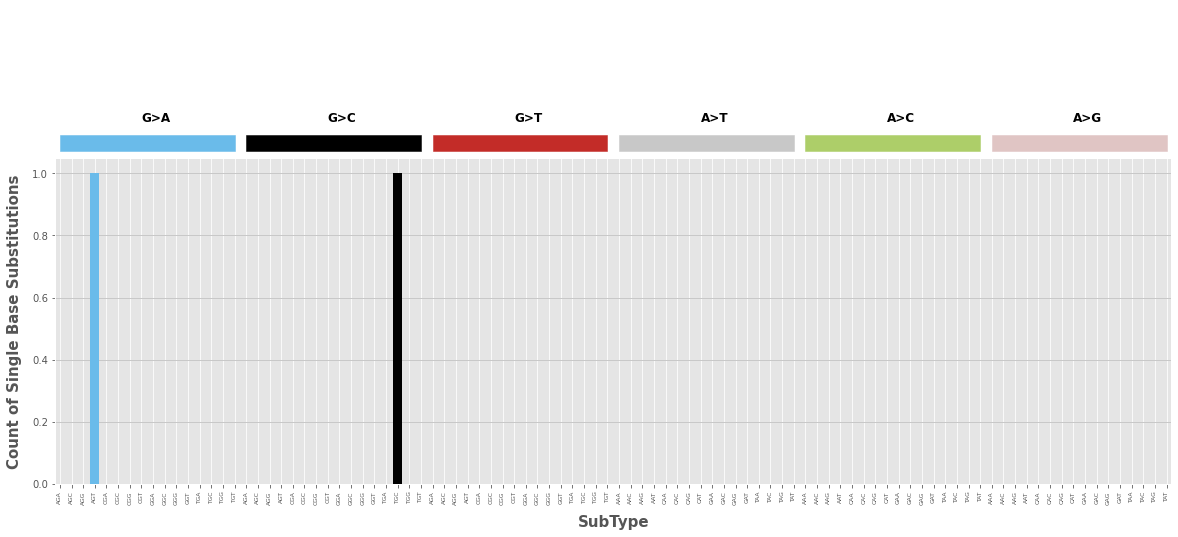

In [36]:
sig_plot(clade="O", base_type="purine", aaf_limit=0.005)

Example: Visualize the variant bases in Clade O sequences with an alternate allele frequency of 0.5% and with a pyrimidine reference base.

11 alternate SNPs included out of a total of 1186 SNPs
0 identified SNPs do not match reference base!
9 total SNPs sorted into SBS-192 classification scheme


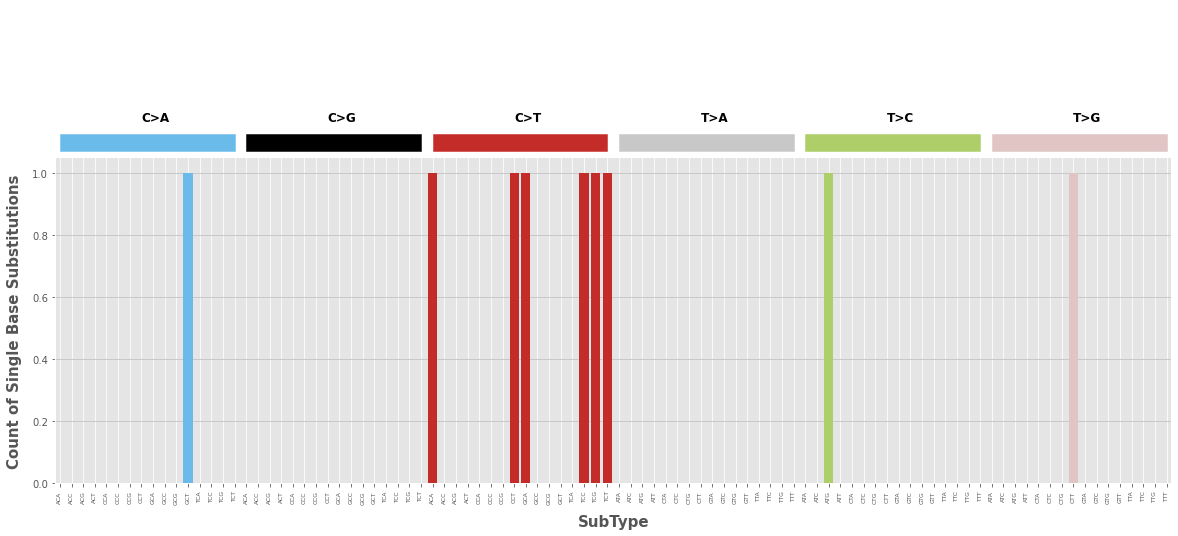

In [37]:
sig_plot(clade="O", base_type="pyrimidine", aaf_limit=0.005)

# Search for all variants in a clade with a substitution at a specific genomic position

In [13]:
def variant_search_position(clade, position):
    data_vcf = read_vcf(clade)
    sample = data_vcf[data_vcf["POS"] == position].loc[:, "NC_045512.2":]
    sample = sample.replace(0, np.nan)
    return sample.dropna(how="all", axis=1).columns.tolist()
    

In [14]:
def variant_search_range(clade, start_position, end_position):
    data_vcf = read_vcf(clade)
    search_df = pd.DataFrame(columns = ["position", "reference_id"])
    for i in range(start_position, end_position + 1):
        sample = data_vcf[data_vcf["POS"] == i].loc[:, "NC_045512.2":]
        sample = sample.replace(0, np.nan)
        reference_id = sample.dropna(how="all", axis=1).columns.tolist() 
        if len(reference_id)>0:
            search_df = search_df.append(pd.DataFrame({"position": [i], "reference_id": [reference_id]}), ignore_index=True)
        else:
            pass
    return search_df

Example: What sequence from Clade O has a variant at position 1002?

In [61]:
variant_search_position(clade="O", position=1002)

['hCoV-19/SaudiArabia/KAUST-JEDDAH1014/2020|EPI_ISL_512885|2020-06-17']

Example: What sequence from Clade O has a variant from position 4000 to 5000? (Note 0 index starts at the first base and end position parameter is inclusive of the end position)

In [75]:
variant_search_range(clade="O", start_position=4000, end_position=5000)

,position,reference_id
0,4085,[hCoV-19/Singapore/1213/2020|EPI_ISL_648629|20...
1,4095,[hCoV-19/Belgium/BJ-0324192/2020|EPI_ISL_42041...
2,4105,[hCoV-19/India/WB-IICB-037/2020|EPI_ISL_661310...
3,4113,[hCoV-19/USA/NY-SURV0983/2020|EPI_ISL_436078|2...
4,4127,[hCoV-19/Japan/DP0077/2020|EPI_ISL_416571|2020...
5,4136,[hCoV-19/Germany/BW-UT-001/2020|EPI_ISL_485809...
6,4144,[hCoV-19/Bahrein/BAH-01/2020|EPI_ISL_483542|20...
7,4158,[hCoV-19/Japan/DP0752/2020|EPI_ISL_416622|2020...
8,4162,[hCoV-19/Japan/DP0803/2020|EPI_ISL_416630|2020...
9,4181,[hCoV-19/India/TG-CCMB-M499/2020|EPI_ISL_49521...


# Search for all variants in a clade with a specific reference to alternate base substitution 

In [15]:
def variant_search_base(clade, ref_base, alt_base):
    data_vcf = read_vcf(clade)
    sample = data_vcf[data_vcf["REF"] == ref_base]
    sample = data_vcf[data_vcf["ALT"] == alt_base].loc[:, "NC_045512.2":]
    sample = sample.replace(0, np.nan)
    return sample.dropna(how="all", axis=1).columns.tolist()

Example: What sequence from Clade O has a reference base of G and alternate base of A?

In [54]:
variant_search_base(clade="O", ref_base="G", alt_base="A")

['hCoV-19/Australia/NSW14/2020|EPI_ISL_413600|2020-03-03',
 'hCoV-19/Australia/VIC123/2020|EPI_ISL_419731|2020-03-20',
 'hCoV-19/Australia/VIC30/2020|EPI_ISL_419749|2020-03-10',
 'hCoV-19/India/UN-1073/2020|EPI_ISL_421662|2020-03-10',
 'hCoV-19/India/UN-1093/2020|EPI_ISL_421663|2020-03-10',
 'hCoV-19/India/UN-1100/2020|EPI_ISL_421664|2020-03-10',
 'hCoV-19/India/UN-1104/2020|EPI_ISL_421665|2020-03-10',
 'hCoV-19/India/UN-1111/2020|EPI_ISL_421666|2020-03-10',
 'hCoV-19/India/UN-1115/2020|EPI_ISL_421667|2020-03-10',
 'hCoV-19/India/UN-1125/2020|EPI_ISL_421668|2020-03-10',
 'hCoV-19/India/UN-1616/2020|EPI_ISL_421669|2020-03-12',
 'hCoV-19/India/UN-1617/2020|EPI_ISL_421670|2020-03-12',
 'hCoV-19/India/UN-1621/2020|EPI_ISL_421671|2020-03-12',
 'hCoV-19/India/UN-1644/2020|EPI_ISL_421672|2020-03-12',
 'hCoV-19/USA/WI-UW-183/2020|EPI_ISL_428279|2020-03-22',
 'hCoV-19/Sri',
 'hCoV-19/Thailand/Bangkok-0039/2020|EPI_ISL_429175|2020-03-28',
 'hCoV-19/Australia/VIC1210/2020|EPI_ISL_430500|2020-04-0

# Search for top n variants with the highest mutation burden

In [16]:
def variant_search_top_n(clade, top_n):
    data_vcf = read_vcf(clade)
    return data_vcf.loc[:, "NC_045512.2":].sum(axis=0).nlargest(top_n)

Example: Return the top n sequences from Clade O with the highest total variant burden

In [58]:
variant_search_top_n(clade="O", top_n=10)

hCoV-19/India/HR-IMT-CB130/2020|EPI_ISL_547592|2020-08-27      9
hCoV-19/England/MILK-800527/2020|EPI_ISL_557185|2020-07-16     9
hCoV-19/Australia/NSW1123/2020|EPI_ISL_593737|2020-09-13       9
hCoV-19/Shenzhen/SZTH-001/2020|EPI_ISL_406592|2020-01-13       8
hCoV-19/England/LOND-1250707/2020|EPI_ISL_665228|2020-10-25    8
hCoV-19/England/LOND-1250AC2/2020|EPI_ISL_665244|2020-11-02    8
hCoV-19/India/UT-AR37/2020|EPI_ISL_511910|2020-05-28           7
hCoV-19/England/QEUH-9994AD/2020|EPI_ISL_559763|2020-08-24     7
hCoV-19/USA/GA-CDC-4459/2020|EPI_ISL_576190|2020-09-11         7
hCoV-19/Canada/MB-NML-1150/2020|EPI_ISL_582477|2020-07-19      7
dtype: int64

# Rainfall Plot Visualization with NC_045512 COVID-19 Reference Genome Annotation Map

In [17]:
def rainfall_plot(clade, aaf_limit):

    reference_dict = {"A": "o","C": "x", "G": "D" , "T":"^" }
    alternate_dict = {"A": "firebrick","C": "gold", "G": "forestgreen" , "T":"royalblue"}
    
    filtered_df = filter_vcf(clade, aaf_limit = aaf_limit)

    filtered_distance = [1]
    for i in range(1, len(filtered_df)):
        filtered_distance.append(filtered_df.iloc[i,0] - filtered_df.iloc[i-1,0])
        
    fig, ax = plt.subplots(figsize=(20, 10))
    for mut in range(len(filtered_df)):
        marker = reference_dict[filtered_df.loc[mut, 'reference']]
        color = alternate_dict[str(filtered_df.loc[mut, 'alternate'][0])]
        ax.scatter(filtered_df.loc[mut,"position"], filtered_distance[mut], c=color, marker=marker)

    ax.set_yscale("log")
    ax.set_xlim([0, 30000])
    ax.set_ylim([1, 100000])
    ax.set_title("Rainfall Plot", pad=150)
    ax.set_xlabel("Genomic Position", labelpad=10)
    ax.set_ylabel("Genomic Distance", labelpad=10)

    A_C = mlines.Line2D([], [], color='gold', marker='o', linestyle='None',
                              markersize=10, label='A>C')
    A_G = mlines.Line2D([], [], color='forestgreen', marker='o', linestyle='None',
                              markersize=10, label='A>G')
    A_T = mlines.Line2D([], [], color='royalblue', marker='o', linestyle='None',
                              markersize=10, label='A>T')

    C_A = mlines.Line2D([], [], color='firebrick', marker='x', linestyle='None',
                              markersize=10, label='C>A')
    C_G = mlines.Line2D([], [], color='forestgreen', marker='x', linestyle='None',
                              markersize=10, label='C>G')
    C_T = mlines.Line2D([], [], color='royalblue', marker='x', linestyle='None',
                              markersize=10, label='C>T')

    G_A = mlines.Line2D([], [], color='firebrick', marker='D', linestyle='None',
                              markersize=10, label='G>A')
    G_C = mlines.Line2D([], [], color='gold', marker='D', linestyle='None',
                              markersize=10, label='G>C')
    G_T = mlines.Line2D([], [], color='royalblue', marker='D', linestyle='None',
                              markersize=10, label='G>T')

    T_A = mlines.Line2D([], [], color='firebrick', marker='^', linestyle='None',
                              markersize=10, label='T>A')
    T_C = mlines.Line2D([], [], color='gold', marker='^', linestyle='None',
                              markersize=10, label='T>C')
    T_G = mlines.Line2D([], [], color='forestgreen', marker='^', linestyle='None',
                              markersize=10, label='T>G')
    fig.patch.set_facecolor('white')
    plt.legend(handles=[A_C, A_G, A_T, C_A, C_G, C_T, G_A, G_C, G_T, T_A, T_C, T_G], title='Variant Classification', bbox_to_anchor=(1.15, 1))

    ax.text(6700, 120000, "ORF1ab", horizontalalignment='center', verticalalignment='center', rotation=0)
    ax.add_patch(patches.Rectangle((266, 99999),13217,50000,linewidth=1,edgecolor='black',facecolor='white', label="ORF1ab", clip_on=False))
    ax.text(400, 280000, "nsp1", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((1, 150000),805,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp1", clip_on=False))
    ax.text(1762, 280000, "nsp2", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((806, 150000),1913,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp2", clip_on=False))
    ax.text(5600, 280000, "nsp3", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((2720, 150000),5834,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp3", clip_on=False))
    ax.text(9300, 280000, "nsp4", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((8555, 150000),1499,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp4", clip_on=False))
    ax.text(10500, 280000, "nsp5", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((10055, 150000),917,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp5", clip_on=False))
    ax.text(11400, 280000, "nsp6", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((10973, 150000),869,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp6", clip_on=False))
    ax.text(12100, 280000, "nsp7", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((11843, 150000),248,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp7", clip_on=False))
    ax.text(12500, 280000, "nsp8", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((12092, 150000),593,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp8", clip_on=False))
    ax.text(12950, 280000, "nsp9", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((12686, 150000),338,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp9", clip_on=False))
    ax.text(13400, 280000, "nsp10", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((13025, 150000),416,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp10", clip_on=False))
    ax.text(13750, 280000, "nsp11", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((13442, 150000),38,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp11", clip_on=False))
    
    ax.text(15100, 280000, "nsp12", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((13480, 150000),2768,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp12", clip_on=False))
    ax.text(17100, 280000, "nsp13", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((16237, 150000),1802,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp13", clip_on=False))
    ax.text(18800, 280000, "nsp14", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((18040, 150000),1580,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp14", clip_on=False))
    ax.text(20100, 280000, "nsp15", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((19621, 150000),1037,50000,linewidth=1,edgecolor='black',facecolor='black', label="nsp15", clip_on=False))
    ax.text(21100, 280000, "nsp16", horizontalalignment='center', verticalalignment='center', rotation=45)
    ax.add_patch(patches.Rectangle((20659, 150000),893,50000,linewidth=1,edgecolor='black',facecolor='none', label="nsp16", clip_on=False))

    ax.text(23400, 230000, "S", rotation=45)
    ax.add_patch(patches.Rectangle((21563, 150000),3821,50000,linewidth=1,edgecolor='black',facecolor='black', label="S", clip_on=False))
    ax.text(25700, 230000, "ORF3a", rotation=45)
    ax.add_patch(patches.Rectangle((25393, 150000),827,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF3a", clip_on=False))
    ax.text(26300, 230000, "E", rotation=45)
    ax.add_patch(patches.Rectangle((26245, 150000),227,50000,linewidth=1,edgecolor='black',facecolor='black', label="E", clip_on=False))
    ax.text(26800, 230000, "M", rotation=45)
    ax.add_patch(patches.Rectangle((26523, 150000),668,50000,linewidth=1,edgecolor='black',facecolor='none', label="M", clip_on=False))
    ax.text(27100, 230000, "ORF6", rotation=45)
    ax.add_patch(patches.Rectangle((27202, 150000),185,50000,linewidth=1,edgecolor='black',facecolor='black', label="ORF6", clip_on=False))
    ax.text(27450, 230000, "ORF7a", rotation=45)
    ax.add_patch(patches.Rectangle((27394, 150000),365,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF7a", clip_on=False))
    ax.text(27750, 230000, "ORF7b", rotation=45)
    ax.add_patch(patches.Rectangle((27756, 150000),131,50000,linewidth=1,edgecolor='black',facecolor='black', label="ORF7b", clip_on=False))
    ax.text(28100, 230000, "ORF8", rotation=45)
    ax.add_patch(patches.Rectangle((27894, 150000),365,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF8", clip_on=False))
    ax.text(28900, 230000, "N", rotation=45)
    ax.add_patch(patches.Rectangle((28274, 150000),1259,50000,linewidth=1,edgecolor='black',facecolor='black', label="N", clip_on=False))
    ax.text(29400, 230000, "ORF10", rotation=45)
    ax.add_patch(patches.Rectangle((29558, 150000),116,50000,linewidth=1,edgecolor='black',facecolor='none', label="ORF10", clip_on=False))
    ax.text(29800, 230000, "3' UTR", rotation=45)
    ax.add_patch(patches.Rectangle((29675, 150000),228,50000,linewidth=1,edgecolor='black',facecolor='black', label="3' UTR", clip_on=False))
    plt.show()

Example: Visualize the variant bases in Clade O sequences with an alternate allele frequency of 1% as a rainfall plot with X-axis as genomic position and Y-axis as log scaled genomic distance from previous variant location. Change alternate allele frequency at your discretion.

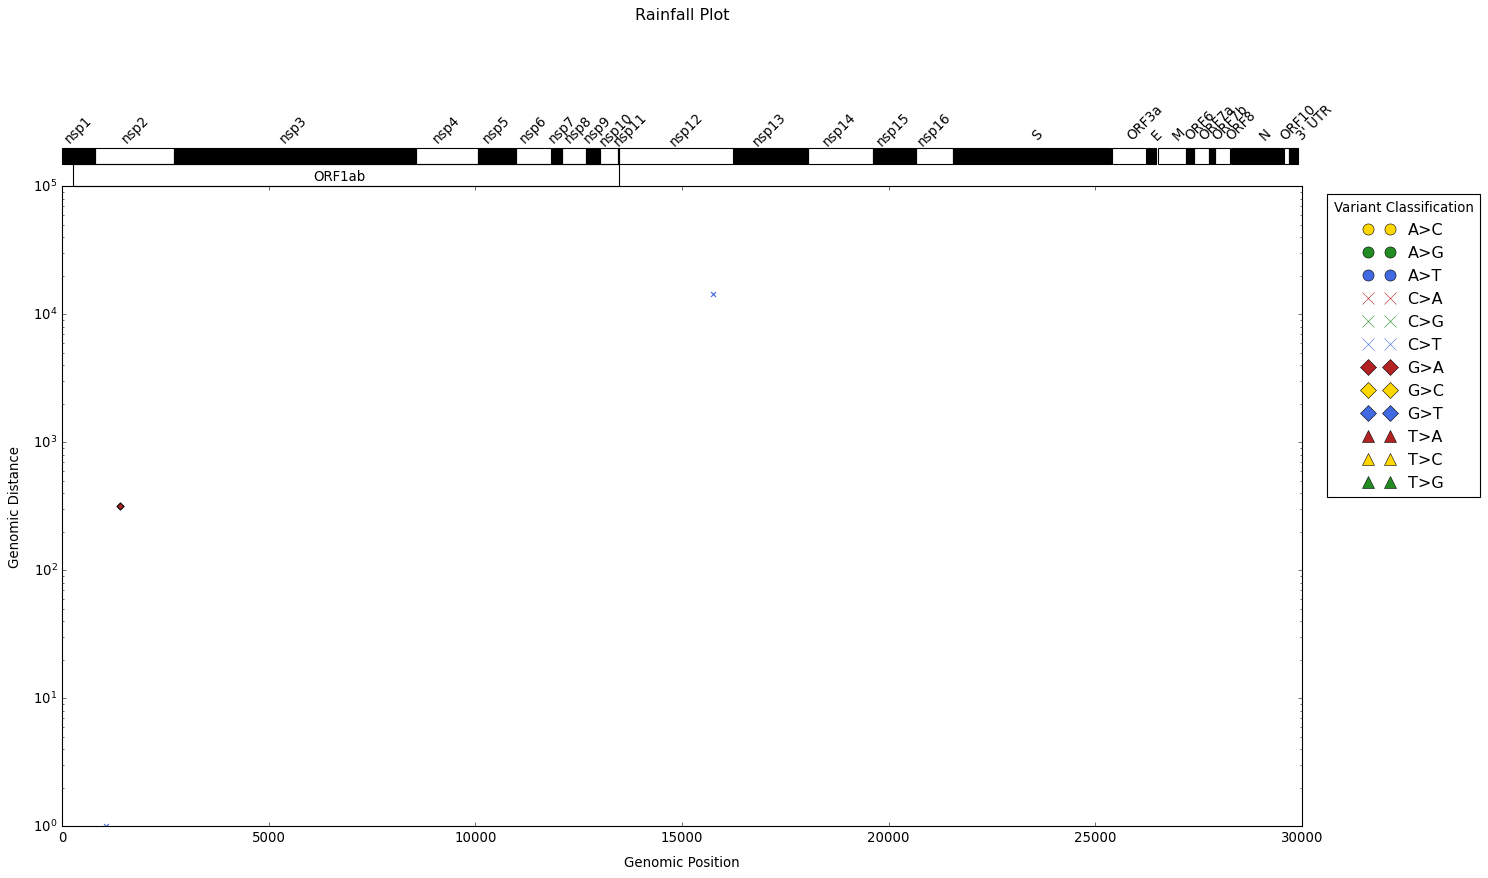

In [113]:
rainfall_plot(clade="O", aaf_limit=0.01)

# Mutation Plot 

Legend plots two symbol markers right now, but I can't seem to fix the issue so if you need a polished version of the legend, just edit out the second symbol using a photo editor like Photoshop or Affinity Photo.

Let me know if you think the auto scale function to adjust figure size is useful. Since some clades have lots more sequences than others, I auto scale the plot so that the height increases. However, the increase can lead to longer graphs that make it easier to see individual points, but may be unwieldly.

In [138]:
def mutation_plot(clade):

    reference_dict = {"A": "o","C": "x", "G": "D" , "T":"^" }
    alternate_dict = {"A": "firebrick","C": "indigo", "G": "forestgreen" , "T":"royalblue"}

    df = read_vcf(clade = clade)
    filtered_df = df.copy().iloc[:, 9:].T

    foo = [x.split("|")[-1] for x in filtered_df.index]

    dates = []
    for d in foo:
        try:
            dates.append(pd.to_datetime(d).date())
        except:
            dates.append(0)
    filtered_df.index = dates
    filtered_df.drop(filtered_df.index[[i for i, x in enumerate(dates) if x == 0]], inplace=True)
    filtered_df.sort_index(inplace=True)
    
    month_index = collections.OrderedDict()
    for month in range(1,13):
        try:
            month_index[month] = list(filtered_df.index).index(pd.to_datetime(str(month) + "-1-2020").date())
        except:
            pass

    fig, ax = plt.subplots(figsize=(16,np.ceil((filtered_df.shape[0]/3000) * 8 )))
    for sequence in tqdm(range(len(filtered_df))):
        rows = filtered_df.iloc[sequence, : ]
        rows = rows[rows>0]
        if len(rows) < 1:
            pass
        else:
            for mutation in list(rows.index):
                try:
                    marker = reference_dict[df.loc[mutation, 'REF']]

                    color = alternate_dict[df.loc[mutation, 'ALT']]
                    plt.scatter(df.loc[mutation, "POS"],sequence,  c=color, marker=marker)
                except:
                    pass

    ax.set_xlim([0, 30000])
    ax.set_ylim([1, filtered_df.shape[0]])
    ax.set_title("Clade " + str(clade) + " Mutation Plot", pad=150)
    ax.set_xlabel("Genomic Position", labelpad=10)
    ax.set_ylabel("Month", labelpad=10)
    ax.set_yticks(list(month_index.values()))
    ax.set_yticklabels(list(month_index.keys()))
    fig.patch.set_facecolor('white')
    
    A_C = mlines.Line2D([], [], color='indigo', marker='o', linestyle='None',
                              markersize=15, label='A>C')
    A_G = mlines.Line2D([], [], color='forestgreen', marker='o', linestyle='None',
                              markersize=15, label='A>G')
    A_T = mlines.Line2D([], [], color='royalblue', marker='o', linestyle='None',
                              markersize=15, label='A>T')

    C_A = mlines.Line2D([], [], color='firebrick', marker='X', linestyle='None',
                              markersize=15, label='C>A')
    C_G = mlines.Line2D([], [], color='forestgreen', marker='X', linestyle='None',
                              markersize=15, label='C>G')
    C_T = mlines.Line2D([], [], color='royalblue', marker='X', linestyle='None',
                              markersize=15, label='C>T')

    G_A = mlines.Line2D([], [], color='firebrick', marker='D', linestyle='None',
                              markersize=15, label='G>A')
    G_C = mlines.Line2D([], [], color='indigo', marker='D', linestyle='None',
                              markersize=15, label='G>C')
    G_T = mlines.Line2D([], [], color='royalblue', marker='D', linestyle='None',
                              markersize=15, label='G>T')

    T_A = mlines.Line2D([], [], color='firebrick', marker='^', linestyle='None',
                              markersize=15, label='T>A')
    T_C = mlines.Line2D([], [], color='indigo', marker='^', linestyle='None',
                              markersize=15, label='T>C')
    T_G = mlines.Line2D([], [], color='forestgreen', marker='^', linestyle='None',
                              markersize=15, label='T>G')

    
    ax.text(6700, filtered_df.shape[0]+200, "ORF1ab", horizontalalignment='center', verticalalignment='center', rotation=0)
    ax.add_patch(patches.Rectangle((266, filtered_df.shape[0]+100),21300,200,linewidth=1,edgecolor='black',facecolor='white', label="ORF1ab", clip_on=False))
    ax.text(400, filtered_df.shape[0]+700, "nsp1", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((1, filtered_df.shape[0]+300),805,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp1", clip_on=False))
    ax.text(1762, filtered_df.shape[0]+700, "nsp2", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((806, filtered_df.shape[0]+300),1913,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp2", clip_on=False))
    ax.text(5600, filtered_df.shape[0]+700, "nsp3", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((2720, filtered_df.shape[0]+300),5834,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp3", clip_on=False))

    ax.text(9300, filtered_df.shape[0]+700, "nsp4", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((8555, filtered_df.shape[0]+300),1499,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp4", clip_on=False))
    ax.text(10500, filtered_df.shape[0]+700, "nsp5", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((10055, filtered_df.shape[0]+300),917,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp5", clip_on=False))
    ax.text(11400, filtered_df.shape[0]+700, "nsp6", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((10973, filtered_df.shape[0]+300),869,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp6", clip_on=False))
    ax.text(12100, filtered_df.shape[0]+700, "nsp7", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((11843, filtered_df.shape[0]+300),248,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp7", clip_on=False))
    ax.text(12500, filtered_df.shape[0]+700, "nsp8", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((12092, filtered_df.shape[0]+300),593,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp8", clip_on=False))
    ax.text(12950, filtered_df.shape[0]+700, "nsp9", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((12686, filtered_df.shape[0]+300),338,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp9", clip_on=False))
    ax.text(13400, filtered_df.shape[0]+700, "nsp10", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((13025, filtered_df.shape[0]+300),416,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp10", clip_on=False))
    ax.text(13750, filtered_df.shape[0]+700, "nsp11", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((13442, filtered_df.shape[0]+300),38,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp11", clip_on=False))

    ax.text(15100, filtered_df.shape[0]+700, "nsp12", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((13480, filtered_df.shape[0]+300),2768,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp12", clip_on=False))
    ax.text(17100, filtered_df.shape[0]+700, "nsp13", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((16237, filtered_df.shape[0]+300),1802,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp13", clip_on=False))
    ax.text(18800, filtered_df.shape[0]+700, "nsp14", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((18040, filtered_df.shape[0]+300),1580,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp14", clip_on=False))
    ax.text(20100, filtered_df.shape[0]+700, "nsp15", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((19621, filtered_df.shape[0]+300),1037,200,linewidth=1,edgecolor='black',facecolor='black', label="nsp15", clip_on=False))
    ax.text(21100, filtered_df.shape[0]+700, "nsp16", horizontalalignment='center', verticalalignment='center', rotation=90)
    ax.add_patch(patches.Rectangle((20659, filtered_df.shape[0]+300),893,200,linewidth=1,edgecolor='black',facecolor='none', label="nsp16", clip_on=False))

    ax.text(23400, filtered_df.shape[0]+600, "S", rotation=90)
    ax.add_patch(patches.Rectangle((21563, filtered_df.shape[0]+300),3821,200,linewidth=1,edgecolor='black',facecolor='black', label="S", clip_on=False))
    ax.text(25700, filtered_df.shape[0]+600, "ORF3a", rotation=90)
    ax.add_patch(patches.Rectangle((25393, filtered_df.shape[0]+300),827,200,linewidth=1,edgecolor='black',facecolor='none', label="ORF3a", clip_on=False))
    ax.text(26300, filtered_df.shape[0]+600, "E", rotation=90)
    ax.add_patch(patches.Rectangle((26245, filtered_df.shape[0]+300),227,200,linewidth=1,edgecolor='black',facecolor='black', label="E", clip_on=False))
    ax.text(26800, filtered_df.shape[0]+600, "M", rotation=90)
    ax.add_patch(patches.Rectangle((26523, filtered_df.shape[0]+300),668,200,linewidth=1,edgecolor='black',facecolor='none', label="M", clip_on=False))
    ax.text(27100,filtered_df.shape[0]+600, "ORF6", rotation=90)
    ax.add_patch(patches.Rectangle((27202, filtered_df.shape[0]+300),185,200,linewidth=1,edgecolor='black',facecolor='black', label="ORF6", clip_on=False))
    ax.text(27450, filtered_df.shape[0]+600, "ORF7a", rotation=90)
    ax.add_patch(patches.Rectangle((27394, filtered_df.shape[0]+300),365,200,linewidth=1,edgecolor='black',facecolor='none', label="ORF7a", clip_on=False))
    ax.text(27750, filtered_df.shape[0]+600, "ORF7b", rotation=90)
    ax.add_patch(patches.Rectangle((27756, filtered_df.shape[0]+300),131,200,linewidth=1,edgecolor='black',facecolor='black', label="ORF7b", clip_on=False))
    ax.text(28100, filtered_df.shape[0]+600, "ORF8", rotation=90)
    ax.add_patch(patches.Rectangle((27894, filtered_df.shape[0]+300),365,200,linewidth=1,edgecolor='black',facecolor='none', label="ORF8", clip_on=False))
    ax.text(28900, filtered_df.shape[0]+600, "N", rotation=90)
    ax.add_patch(patches.Rectangle((28274, filtered_df.shape[0]+300),1259,200,linewidth=1,edgecolor='black',facecolor='black', label="N", clip_on=False))
    ax.text(29400, filtered_df.shape[0]+600, "ORF10", rotation=90)
    ax.add_patch(patches.Rectangle((29558, filtered_df.shape[0]+300),116,200,linewidth=1,edgecolor='black',facecolor='none', label="ORF10", clip_on=False))
    ax.text(29800, filtered_df.shape[0]+600, "3' UTR", rotation=90)
    ax.add_patch(patches.Rectangle((29675, filtered_df.shape[0]+300),228,200,linewidth=1,edgecolor='black',facecolor='black', label="3' UTR", clip_on=False))

    plt.legend(handles=[A_C, A_G, A_T, C_A, C_G, C_T, G_A, G_C, G_T, T_A, T_C, T_G], title='Variant Classification', bbox_to_anchor=(1.2, 1))
    plt.show()

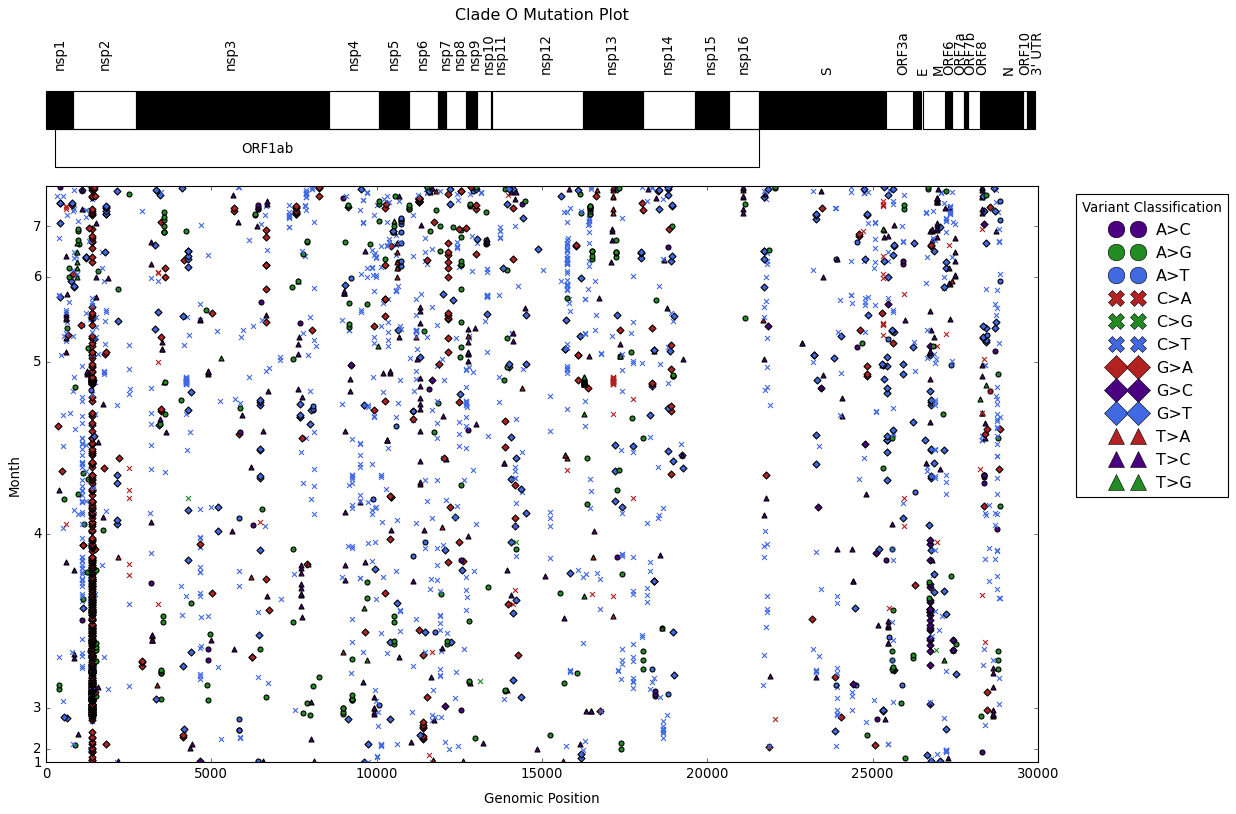

In [139]:
mutation_plot(clade = "O")

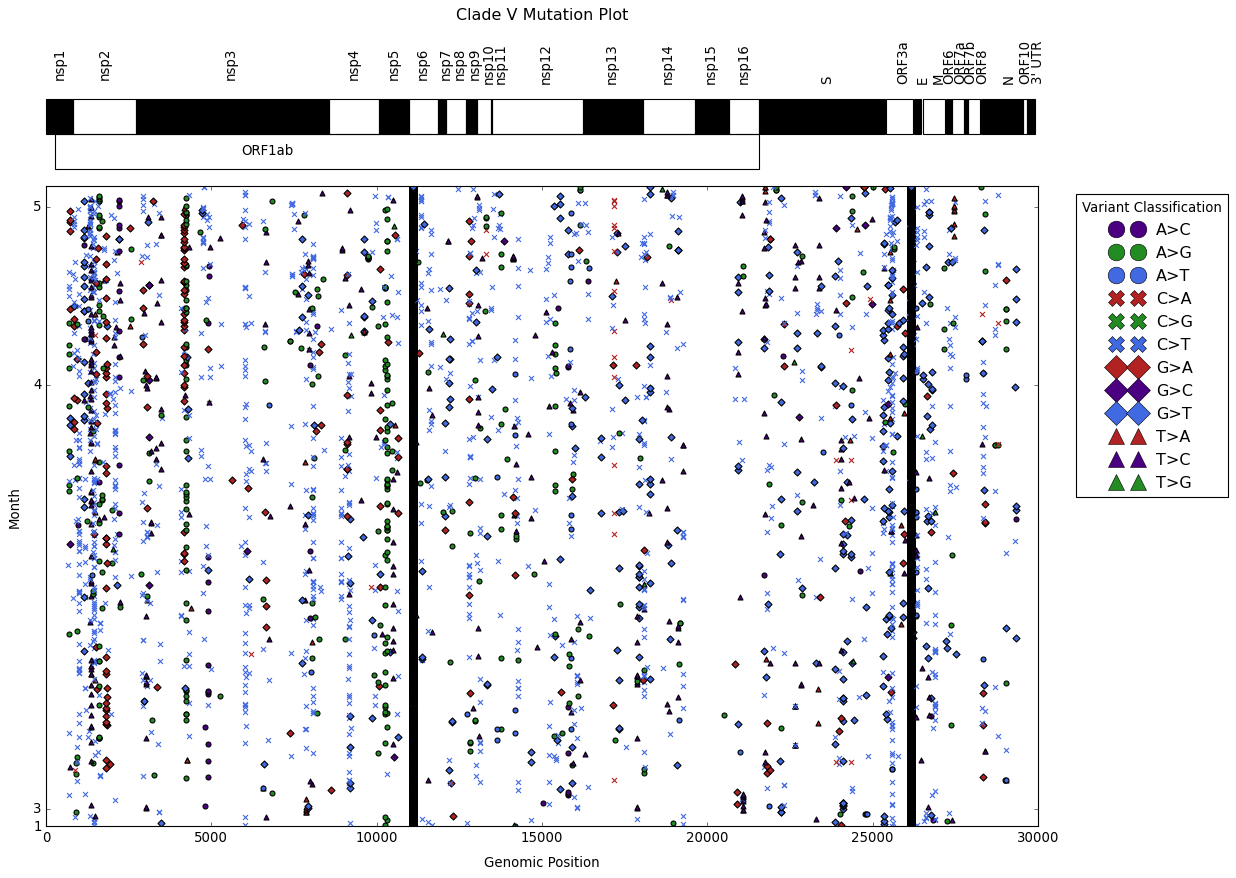

In [140]:
mutation_plot(clade = "V")

In [ ]:
mutation_plot(clade = "S")

In [ ]:
mutation_plot(clade = "L")

In [ ]:
mutation_plot(clade = "G")

In [ ]:
mutation_plot(clade = "GR")

In [ ]:
mutation_plot(clade = "GH")